# Basic Simulation

## Setting Up a Manufacturer

### Basic Configuration

In [1]:
import numpy as np

from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.config_v2 import ManufacturerConfig

# Create a medium-sized manufacturer
mfg_config = ManufacturerConfig(
    initial_assets=10_000_000,    # Starting with $10M
    asset_turnover_ratio=1.0,     # Generate revenue equal to assets
    base_operating_margin=0.12,        # Profit margin before losses
    tax_rate=0.25,                # 25% corporate tax
    retention_ratio=0.7           # Retain 70% of earnings
)

# Note: WorkingCapitalConfig is not passed to WidgetManufacturer
# Working capital percentage is set when calling step() method
manufacturer = WidgetManufacturer(mfg_config)

# Calculate key metrics
annual_revenue = manufacturer.assets * manufacturer.asset_turnover_ratio
operating_income = annual_revenue * manufacturer.base_operating_margin
net_income = operating_income * (1 - manufacturer.tax_rate)

print(f"Company Financial Profile:")
print(f"  Assets: ${manufacturer.assets:,.0f}")
print(f"  Annual Revenue: ${annual_revenue:,.0f}")
print(f"  Operating Income: ${operating_income:,.0f}")
print(f"  Net Income: ${net_income:,.0f}")
print(f"  ROA: {net_income / manufacturer.assets:.1%}")

Company Financial Profile:
  Assets: $10,000,000
  Annual Revenue: $10,000,000
  Operating Income: $1,200,000
  Net Income: $900,000
  ROA: 9.0%


### Sector-Specific Configurations

In [2]:
import numpy as np

from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.config_v2 import ManufacturerConfig

# Capital-intensive manufacturing
heavy_industry = WidgetManufacturer(ManufacturerConfig(
    initial_assets=50_000_000,
    asset_turnover_ratio=0.5,  # Low turnover
    base_operating_margin=0.05,     # 5% margins
    tax_rate=0.25,
    retention_ratio=0.7
))

# High-efficiency light manufacturer (e.g., consumer goods, textiles)
light_manufacturer = WidgetManufacturer(ManufacturerConfig(
    initial_assets=5_000_000,
    asset_turnover_ratio=2.0,  # High turnover - efficient asset use
    base_operating_margin=0.08,     # Moderate margins
    tax_rate=0.25,
    retention_ratio=0.6        # Lower retention due to distribution needs
))

# High-tech manufacturer (e.g., semiconductors, medical devices)
high_tech = WidgetManufacturer(ManufacturerConfig(
    initial_assets=25_000_000,  # Capital intensive
    asset_turnover_ratio=0.8,   # Moderate turnover
    base_operating_margin=0.35,       # High margins from IP/technology
    tax_rate=0.21,              # Lower effective tax rate
    retention_ratio=0.85        # High retention for R&D investment
))

# Compare profitability
for company, name in [
    (heavy_industry, "Heavy Industry"),
    (light_manufacturer, "Light Manufacturer"),
    (high_tech, "High-Tech")
]:
    revenue = company.assets * company.asset_turnover_ratio
    profit = revenue * company.base_operating_margin * (1 - company.tax_rate)
    roe = profit / company.assets
    print(f"{name}:")
    print(f"  Assets: ${company.assets:,.0f}")
    print(f"  Revenue: ${revenue:,.0f}")
    print(f"  ROE: {roe:.1%}")
    print()

Heavy Industry:
  Assets: $50,000,000
  Revenue: $25,000,000
  ROE: 1.9%

Light Manufacturer:
  Assets: $5,000,000
  Revenue: $10,000,000
  ROE: 12.0%

High-Tech:
  Assets: $25,000,000
  Revenue: $20,000,000
  ROE: 22.1%



## Generating Losses

### Basic Loss Generation

In [3]:
import numpy as np

from ergodic_insurance.claim_generator import ClaimGenerator

# Standard loss generator
standard_losses = ClaimGenerator(
    base_frequency=5,
    severity_mean=80_000,
    severity_std=65_000
)

# Generate 5 years of losses
sim_years = 5
standard_losses.rng.seed(42)  # For reproducibility
losses_by_year = standard_losses.generate_claims(years=sim_years)
for year in range(sim_years):
    annual_losses = [loss for loss in losses_by_year if loss.year == year]
    annual_total = sum(loss.amount for loss in annual_losses)
    print(f"Year {year+1}: {len(annual_losses)} losses, Total: ${annual_total:,.0f}")

Year 1: 5 losses, Total: $478,808
Year 2: 5 losses, Total: $328,959
Year 3: 3 losses, Total: $148,976
Year 4: 4 losses, Total: $210,324
Year 5: 9 losses, Total: $488,578


### Different Risk Profiles

In [4]:
from ergodic_insurance.claim_generator import ClaimGenerator

# Low frequency, high severity (catastrophic risk)
catastrophic_risk = ClaimGenerator(
    base_frequency=0.1,         # One loss every 10 years
    severity_mean=1_000_000,      # Much larger losses
    severity_std=500_000     # More variability
)

# High frequency, low severity (operational risk)
operational_risk = ClaimGenerator(
    base_frequency=20,          # Many small losses
    severity_mean=3_000,       # Smaller losses
    severity_std=1_000     # Less variability
)

# Simulate and compare
np.random.seed(42)
years = 10
risk_profiles = {
    "Standard": standard_losses,
    "Catastrophic": catastrophic_risk,
    "Operational": operational_risk
}

all_losses = []
for name, generator in risk_profiles.items():
    generator_losses = []
    for year in range(years):
        generator.rng.seed(42 + year)  # Different seed each year
        annual = generator.generate_year(year=year)
        generator_losses.extend(annual)

    if generator_losses:
        print(f"\n{name} Risk Profile ({years} years):")
        print(f"  Total losses: {len(generator_losses)}")
        print(f"  Average loss: ${np.mean([loss.amount for loss in generator_losses]):,.0f}")
        print(f"  Largest loss: ${max(loss.amount for loss in generator_losses):,.0f}")
        print(f"  Total amount: ${sum(loss.amount for loss in generator_losses):,.0f}")

    all_losses.extend(generator_losses)


Standard Risk Profile (10 years):
  Total losses: 46
  Average loss: $76,491
  Largest loss: $233,220
  Total amount: $3,518,578

Catastrophic Risk Profile (10 years):
  Total losses: 1
  Average loss: $742,130
  Largest loss: $742,130
  Total amount: $742,130

Operational Risk Profile (10 years):
  Total losses: 202
  Average loss: $2,936
  Largest loss: $8,345
  Total amount: $593,058


## Running Simulations

### Single Path Simulation

In [5]:
from ergodic_insurance.insurance import InsurancePolicy, InsuranceLayer
from ergodic_insurance.simulation import Simulation

### Using previously defined manufacturer and losses #######

# Policy parameters
deductible = 200_000
limit = 40_000_000

### Calculate a fair premium #######
# Calculate pure premium
total_covered_losses = sum(min(max(0, loss.amount - deductible), limit) \
                            for loss in all_losses)
pure_premium = total_covered_losses / years  # As a fraction of assets
loss_ratio = 0.70  # 70% of premiums go towards losses
reasonable_premium = pure_premium / loss_ratio
reasonable_rate = reasonable_premium / limit
print(f"Calculated Reasonable Premium: ${reasonable_premium:,.0f}")

### Set up the policy #######
single_layer = InsuranceLayer(
    attachment_point=deductible,
    limit=limit,
    rate=reasonable_rate
)

insurance_policy = InsurancePolicy(
    layers=[single_layer],
    deductible=deductible
)

### Set up the simulation #######
sim = Simulation(
    manufacturer=heavy_industry,
    claim_generator=[standard_losses, catastrophic_risk, operational_risk],
    insurance_policy=insurance_policy,
    time_horizon=20,  # 20-year simulation
    seed=42
)

results = sim.run()
result_summary = results.summary_stats()

print(f"20-Year Simulation Results:")
print(f"Starting Assets: ${heavy_industry.config.initial_assets:,.0f}")
print(f"Final Assets: ${result_summary['final_assets']:,.0f}")
print(f"Final Assets: ${result_summary['final_assets']:,.0f}")
print(f"Time-Weighted ROE: {result_summary['time_weighted_roe']:.2%}")

Calculated Reasonable Premium: $85,661
20-Year Simulation Results:
Starting Assets: $50,000,000
Final Assets: $53,379,921
Final Assets: $53,379,921
Time-Weighted ROE: 1.82%


### Monte Carlo Simulation

In [6]:
from ergodic_insurance.monte_carlo import MonteCarloEngine, SimulationConfig
from ergodic_insurance.insurance_program import InsuranceProgram, EnhancedInsuranceLayer
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

# Create a ManufacturingLossGenerator for Monte Carlo simulation
# (MonteCarloEngine expects this type, not ClaimGenerator)
mc_loss_generator = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 3.0,  # Similar to standard_losses frequency
        'severity_mean': 40_000,  # Similar to standard_losses severity
        'severity_cv': 0.8  # Coefficient of variation
    },
    large_params={
        'base_frequency': 0.1,  # Occasional large losses
        'severity_mean': 500_000,
        'severity_cv': 1.2
    },
    seed=42
)

# Create insurance program with enhanced layers
# EnhancedInsuranceLayer has the required methods for InsuranceProgram
insurance_layers = [
    EnhancedInsuranceLayer(
        attachment_point=100_000,    # $100K deductible
        limit=10_000_000,            # $10M limit
        premium_rate=0.015            # 2% rate on limit
    )
]
insurance_program = InsuranceProgram(layers=insurance_layers)

# Configure Monte Carlo simulation
mc_config = SimulationConfig(
    n_simulations=1000,
    n_years=20,
    parallel=False,  # Set to False for simpler execution
    progress_bar=True,
    seed=42
)

# Create Monte Carlo engine
mc_engine = MonteCarloEngine(
    loss_generator=mc_loss_generator,
    insurance_program=insurance_program,
    manufacturer=heavy_industry,
    config=mc_config
)

# Run simulations
print("Running Monte Carlo simulations...")
mc_results = mc_engine.run()

# Extract results
survival_rate = 1 - mc_results.ruin_probability
mean_growth = np.mean(mc_results.growth_rates)
median_growth = np.median(mc_results.growth_rates)
var_95 = np.percentile(mc_results.growth_rates, 5)
mean_final_assets = np.mean(mc_results.final_assets)

print(f"\nMonte Carlo Results (1000 simulations):")
print(f"  Survival Rate: {survival_rate:.1%}")
print(f"  Mean Growth Rate: {mean_growth:.2%}")
print(f"  Median Growth Rate: {median_growth:.2%}")
print(f"  95% VaR Growth: {var_95:.2%}")
print(f"  Starting Wealth: ${mc_engine.manufacturer._initial_assets:,.0f}")
print(f"  Mean Final Wealth: ${mean_final_assets:,.0f}")

Running Monte Carlo simulations...


Running simulations: 100%|██████████| 1000/1000 [00:01<00:00, 553.48it/s]



Monte Carlo Results (1000 simulations):
  Survival Rate: 100.0%
  Mean Growth Rate: 0.51%
  Median Growth Rate: 0.56%
  95% VaR Growth: 0.03%
  Starting Wealth: $50,000,000
  Mean Final Wealth: $59,211,744


### Comparing Insurance Strategies

In [7]:
# Define different insurance strategies
strategies = [
    {"name": "No Insurance", "attachment": float('inf'), "limit": 0, "premium_rate": 0},
    {"name": "High Deductible", "attachment": 2_000_000, "limit": 10_000_000, "premium_rate": 0.01},
    {"name": "Medium Coverage", "attachment": 500_000, "limit": 5_000_000, "premium_rate": 0.015},
    {"name": "Full Coverage", "attachment": 100_000, "limit": 20_000_000, "premium_rate": 0.02}
]

# Run simulations for each strategy
results_comparison = {}

for strategy in strategies:
    # Create insurance layers for this strategy
    if strategy['limit'] > 0:
        strategy_layers = [
            EnhancedInsuranceLayer(
                attachment_point=strategy['attachment'],
                limit=strategy['limit'],
                premium_rate=strategy['premium_rate']
            )
        ]
        strategy_insurance = InsuranceProgram(layers=strategy_layers)
    else:
        # No insurance case
        strategy_insurance = InsuranceProgram(layers=[])
    
    # Configure simulation for this strategy
    strategy_config = SimulationConfig(
        n_simulations=500,
        n_years=20,
        parallel=False,
        progress_bar=False,  # Disable for cleaner output
        seed=42
    )
    
    # Create new engine for this strategy
    strategy_engine = MonteCarloEngine(
        loss_generator=mc_loss_generator,
        insurance_program=strategy_insurance,
        manufacturer=heavy_industry.copy(),  # Use a copy to ensure independence
        config=strategy_config
    )
    
    # Run simulations
    print(f"Running {strategy['name']}...")
    strategy_results = strategy_engine.run()
    results_comparison[strategy['name']] = strategy_results

# Compare strategies
print("\nStrategy Comparison:")
print(f"{'Strategy':<20} {'Survival':<12} {'Mean Growth':<12} {'Volatility':<12}")
print("-" * 56)

for name, results in results_comparison.items():
    survival = 1 - results.ruin_probability
    mean_growth = np.mean(results.growth_rates)
    vol = np.std(results.growth_rates)
    print(f"{name:<20} {survival:>10.1%}   {mean_growth:>10.2%}   {vol:>10.2%}")

Running No Insurance...


c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Running High Deductible...
Running Medium Coverage...
Running Full Coverage...

Strategy Comparison:
Strategy             Survival     Mean Growth  Volatility  
--------------------------------------------------------
No Insurance             100.0%        1.02%        0.23%
High Deductible          100.0%        0.89%        0.28%
Medium Coverage          100.0%        0.93%        0.23%
Full Coverage            100.0%        0.59%        0.26%


## Visualizing Results

### Wealth Trajectories

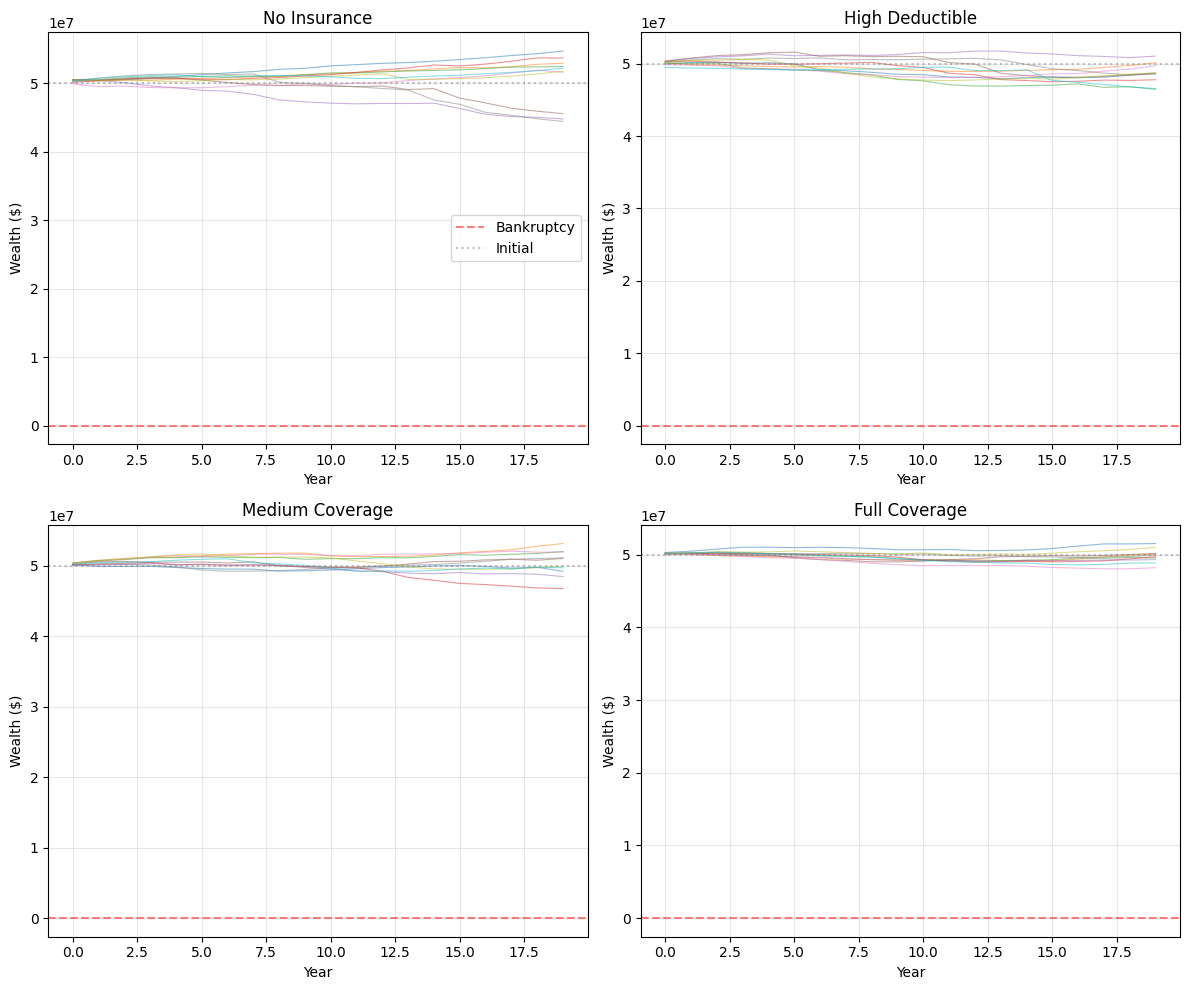

In [8]:
import matplotlib.pyplot as plt
from ergodic_insurance.simulation import Simulation

# Run simulation with multiple seeds
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
strategies_to_plot = strategies[:4]

for ax, strategy in zip(axes.flat, strategies_to_plot):
    # Run 10 simulations with different seeds for this strategy
    trajectories = []
    
    for seed in range(10):
        # Create insurance policy for this strategy
        if strategy['limit'] > 0:
            strategy_layer = InsuranceLayer(
                attachment_point=strategy['attachment'],
                limit=strategy['limit'],
                rate=strategy['premium_rate']
            )
            strategy_policy = InsurancePolicy(
                layers=[strategy_layer],
                deductible=strategy['attachment']
            )
        else:
            # No insurance case
            strategy_policy = InsurancePolicy(layers=[], deductible=float('inf'))
        
        # Create and run simulation
        strategy_sim = Simulation(
            manufacturer=heavy_industry.copy(),  # Use a copy for independence
            claim_generator=[standard_losses, catastrophic_risk, operational_risk],
            insurance_policy=strategy_policy,
            time_horizon=20,
            seed=seed
        )
        
        result = strategy_sim.run()
        
        # Extract wealth trajectory from the assets array
        trajectories.append(result.assets)
    
    # Plot trajectories
    for traj in trajectories:
        ax.plot(range(len(traj)), traj, alpha=0.5, linewidth=0.8)
    
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Bankruptcy')
    ax.axhline(y=heavy_industry.config.initial_assets, color='gray', 
               linestyle=':', alpha=0.5, label='Initial')
    ax.set_title(strategy['name'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Wealth ($)')
    ax.grid(True, alpha=0.3)
    
    # Only show legend on first subplot
    if ax == axes.flat[0]:
        ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Distribution of Outcomes

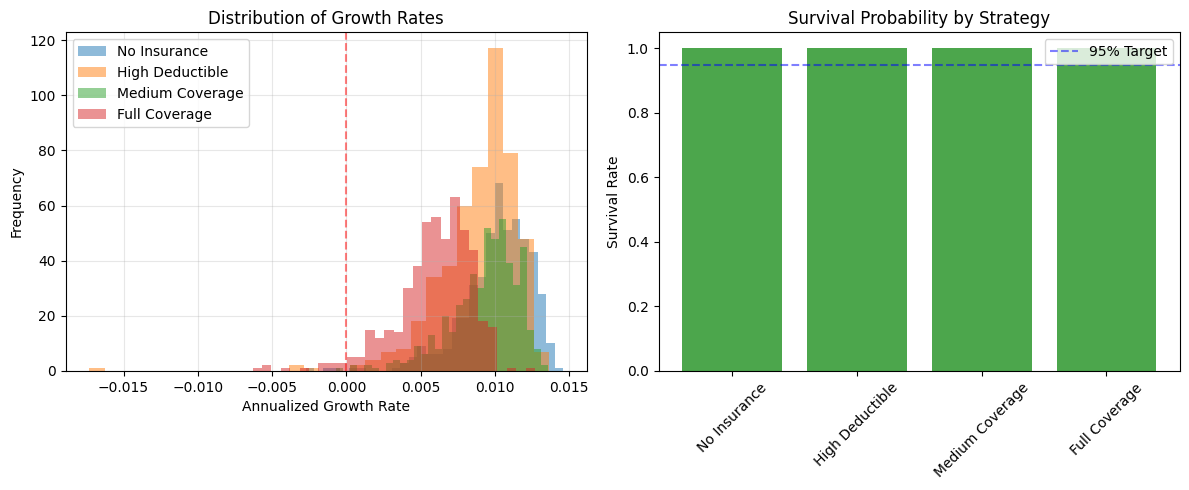

In [9]:
# Plot distribution of final wealth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Growth rate distribution
ax1 = axes[0]
for name, results in results_comparison.items():
    ax1.hist(results.growth_rates, bins=30, alpha=0.5, label=name)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Annualized Growth Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Growth Rates')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Survival analysis
ax2 = axes[1]
names = list(results_comparison.keys())
# Calculate survival rates from ruin_probability
survival_rates = [1 - results_comparison[name].ruin_probability for name in names]
colors = ['red' if sr < 0.95 else 'green' for sr in survival_rates]
ax2.bar(names, survival_rates, color=colors, alpha=0.7)
ax2.axhline(y=0.95, color='blue', linestyle='--', alpha=0.5, label='95% Target')
ax2.set_ylabel('Survival Rate')
ax2.set_title('Survival Probability by Strategy')
ax2.legend()
ax2.set_ylim([0, 1.05])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Risk-Return Scatter

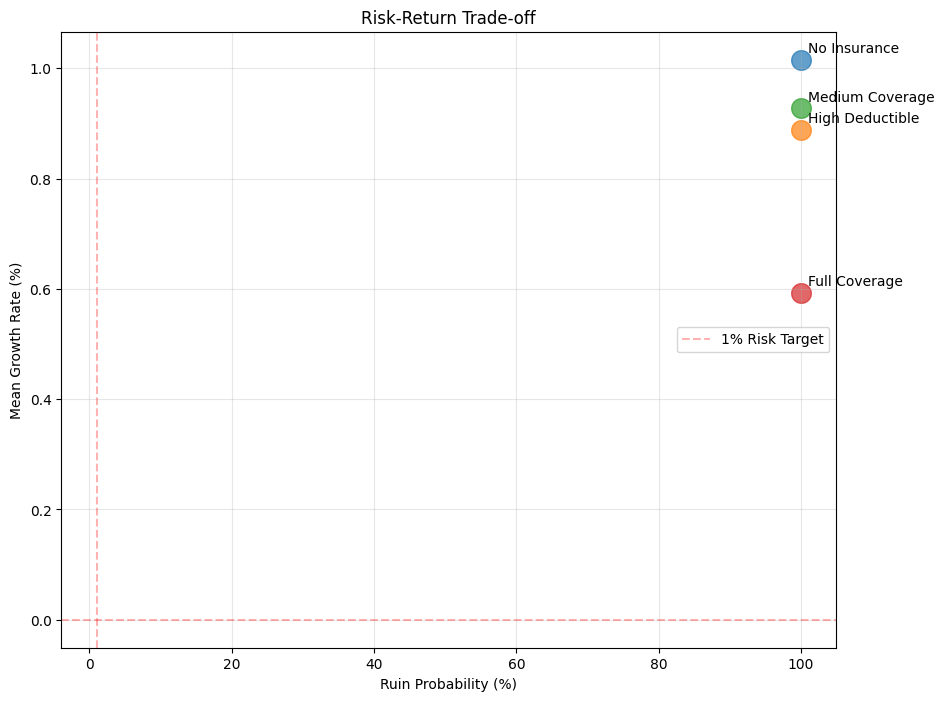

In [10]:
# Create risk-return scatter plot
plt.figure(figsize=(10, 8))

for name, results in results_comparison.items():
    mean_return = np.mean(results.growth_rates)
    risk = 1 - results.ruin_probability  # Ruin probability as risk

    plt.scatter(risk * 100, mean_return * 100, s=200, alpha=0.7)
    plt.annotate(name, (risk * 100, mean_return * 100),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Ruin Probability (%)')
plt.ylabel('Mean Growth Rate (%)')
plt.title('Risk-Return Trade-off')
plt.grid(True, alpha=0.3)

# Add efficient frontier concept
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.3, label='1% Risk Target')
plt.legend(loc='best')
plt.show()

## Advanced Simulation Features

### Using Different Random Processes

In [11]:
from ergodic_insurance.stochastic_processes import GeometricBrownianMotion, StochasticConfig
from ergodic_insurance.simulation import Simulation

# Create a stochastic process for revenue volatility
# This adds market volatility to the manufacturer's revenue generation
stochastic_config = StochasticConfig(
    drift=0.05,         # 5% drift (growth trend)
    volatility=0.15,    # 15% volatility (market uncertainty)
    time_step=1.0,      # Annual time step
    random_seed=42      # For reproducibility
)

gbm = GeometricBrownianMotion(stochastic_config)

# Create a stochastic version of heavy_industry
stochastic_manufacturer = WidgetManufacturer(
    config=heavy_industry.config,  # Use same configuration
    stochastic_process=gbm         # Add stochastic process
)

# Compare deterministic vs stochastic simulations
comparison_results = {}

# Run deterministic simulation (no stochastic process)
print("Running deterministic simulation...")
deterministic_sim = Simulation(
    manufacturer=heavy_industry.copy(),
    claim_generator=[standard_losses],
    insurance_policy=insurance_policy,
    time_horizon=20,
    seed=42
)
det_result = deterministic_sim.run()
comparison_results['Deterministic'] = det_result

# Run stochastic simulation (with GBM process)
print("Running stochastic simulation...")
stochastic_sim = Simulation(
    manufacturer=stochastic_manufacturer.copy(),
    claim_generator=[standard_losses],
    insurance_policy=insurance_policy,
    time_horizon=20,
    seed=42
)
# Note: The step() method in manufacturer will apply stochastic shocks when available
stoch_result = stochastic_sim.run()
comparison_results['Stochastic'] = stoch_result

# Compare results
print("\n" + "="*50)
print("Deterministic vs Stochastic Comparison")
print("="*50)

for name, result in comparison_results.items():
    stats = result.summary_stats()
    print(f"\n{name} Simulation:")
    print(f"  Final Assets: ${stats['final_assets']:,.0f}")
    print(f"  Mean ROE: {stats['mean_roe']:.2%}")
    print(f"  ROE Volatility: {stats['roe_std']:.2%}")
    print(f"  Survived: {stats['survived']}")
    if not stats['survived']:
        print(f"  Insolvency Year: {result.insolvency_year}")

Running deterministic simulation...
Running stochastic simulation...

Deterministic vs Stochastic Comparison

Deterministic Simulation:
  Final Assets: $51,132,355
  Mean ROE: 1.72%
  ROE Volatility: 0.53%
  Survived: True

Stochastic Simulation:
  Final Assets: $55,664,614
  Mean ROE: 1.95%
  ROE Volatility: 0.64%
  Survived: True


### Monte Carlo with Stochastic Processes

Running Monte Carlo for Low Volatility...
Running Monte Carlo for Medium Volatility...


c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Running Monte Carlo for High Volatility...


c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]



Impact of Market Volatility on Insurance Effectiveness
Scenario             Survival     Mean Growth     Growth Vol  
------------------------------------------------------------
Low Volatility           100.0%          1.26%        0.29%
Medium Volatility        100.0%          0.96%        0.29%
High Volatility          100.0%          0.66%        0.22%


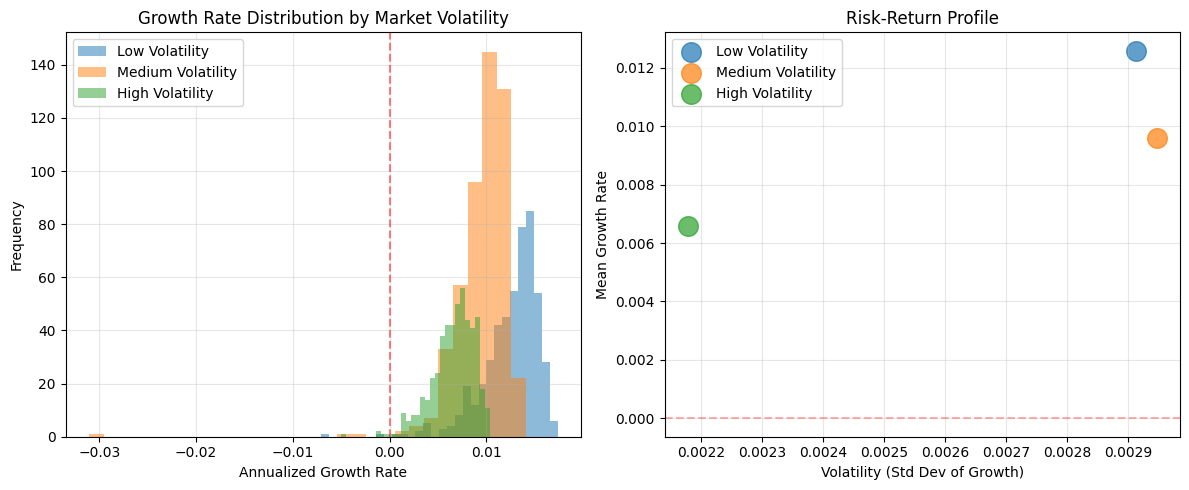

In [12]:
# Create manufacturers with different volatility levels
volatility_scenarios = {
    "Low Volatility": StochasticConfig(drift=0.03, volatility=0.05, random_seed=42),
    "Medium Volatility": StochasticConfig(drift=0.03, volatility=0.15, random_seed=42),
    "High Volatility": StochasticConfig(drift=0.03, volatility=0.25, random_seed=42)
}

# Test with medium coverage insurance strategy
test_insurance = InsuranceProgram(layers=[
    EnhancedInsuranceLayer(
        attachment_point=500_000,
        limit=5_000_000,
        premium_rate=0.015
    )
])

# Run Monte Carlo for each volatility scenario
volatility_results = {}

for vol_name, stoch_config in volatility_scenarios.items():
    print(f"Running Monte Carlo for {vol_name}...")
    
    # Create manufacturer with stochastic process
    gbm_process = GeometricBrownianMotion(stoch_config)
    vol_manufacturer = WidgetManufacturer(
        config=heavy_industry.config,
        stochastic_process=gbm_process
    )
    
    # Configure Monte Carlo
    mc_config = SimulationConfig(
        n_simulations=500,
        n_years=20,
        parallel=False,
        progress_bar=False,
        seed=42
    )
    
    # Run Monte Carlo
    mc_engine = MonteCarloEngine(
        loss_generator=mc_loss_generator,
        insurance_program=test_insurance,
        manufacturer=vol_manufacturer,
        config=mc_config
    )
    
    vol_results = mc_engine.run()
    volatility_results[vol_name] = vol_results

# Analyze impact of volatility
print("\n" + "="*60)
print("Impact of Market Volatility on Insurance Effectiveness")
print("="*60)
print(f"{'Scenario':<20} {'Survival':<12} {'Mean Growth':<15} {'Growth Vol':<12}")
print("-"*60)

for name, results in volatility_results.items():
    survival = 1 - results.ruin_probability
    mean_growth = np.mean(results.growth_rates)
    growth_vol = np.std(results.growth_rates)
    print(f"{name:<20} {survival:>10.1%}   {mean_growth:>12.2%}   {growth_vol:>10.2%}")

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Growth rate distributions
ax1 = axes[0]
for name, results in volatility_results.items():
    ax1.hist(results.growth_rates, bins=30, alpha=0.5, label=name)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Annualized Growth Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Growth Rate Distribution by Market Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk-return scatter
ax2 = axes[1]
for name, results in volatility_results.items():
    mean_return = np.mean(results.growth_rates)
    vol_return = np.std(results.growth_rates)
    survival = 1 - results.ruin_probability
    # Size proportional to survival rate
    ax2.scatter(vol_return, mean_return, s=survival*200, alpha=0.7, label=name)

ax2.set_xlabel('Volatility (Std Dev of Growth)')
ax2.set_ylabel('Mean Growth Rate')
ax2.set_title('Risk-Return Profile')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add efficient frontier reference line
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Parallel Processing

In [13]:
# Parallel processing considerations on Windows
# Note: On Windows, parallel processing often has significant overhead due to process spawning
# It's only beneficial for large simulations (typically >5000 simulations)

import time
import warnings

# Create insurance program for test
parallel_insurance = InsuranceProgram(layers=[
    EnhancedInsuranceLayer(
        attachment_point=1_000_000,
        limit=10_000_000,
        premium_rate=0.02
    )
])

print("="*60)
print("Parallel Processing Performance Test")
print("="*60)

# Test with different simulation sizes
test_sizes = [500, 1000, 5000, 10000]
results_comparison = {}

for n_sims in test_sizes:
    print(f"\nTesting with {n_sims} simulations:")
    print("-" * 40)
    
    # Sequential execution
    start_time = time.time()
    sequential_config = SimulationConfig(
        n_simulations=n_sims,
        n_years=20,  # Reduced years for faster testing
        parallel=False,
        progress_bar=False,  # Disable for cleaner output
        seed=42
    )
    
    sequential_engine = MonteCarloEngine(
        loss_generator=mc_loss_generator,
        insurance_program=parallel_insurance,
        manufacturer=heavy_industry.copy(),
        config=sequential_config
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sequential_results = sequential_engine.run()
    sequential_time = time.time() - start_time
    
    # Standard parallel execution (not enhanced)
    start_time = time.time()
    parallel_config = SimulationConfig(
        n_simulations=n_sims,
        n_years=20,
        parallel=True,
        n_workers=-2,
        use_enhanced_parallel=False,  # Disable enhanced parallel to avoid Windows issues
        progress_bar=False,
        seed=42
    )
    
    parallel_engine = MonteCarloEngine(
        loss_generator=mc_loss_generator,
        insurance_program=parallel_insurance,
        manufacturer=heavy_industry.copy(),
        config=parallel_config
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        parallel_results = parallel_engine.run()
    parallel_time = time.time() - start_time
    
    # Store results
    results_comparison[n_sims] = {
        'sequential_time': sequential_time,
        'parallel_time': parallel_time,
        'speedup': sequential_time / parallel_time if parallel_time > 0 else 0
    }
    
    print(f"  Sequential: {sequential_time:.2f}s")
    print(f"  Parallel:   {parallel_time:.2f}s")
    print(f"  Speedup:    {results_comparison[n_sims]['speedup']:.2f}x")
    
    # Verify results match
    seq_survival = 1 - sequential_results.ruin_probability
    par_survival = 1 - parallel_results.ruin_probability
    if abs(seq_survival - par_survival) < 0.01:
        print(f"  ✓ Results match (survival ~{seq_survival:.1%})")
    else:
        print(f"  ⚠ Results differ: seq={seq_survival:.1%}, par={par_survival:.1%}")

# Recommendations
print("\n" + "="*60)
print("Recommendations for Your System")
print("="*60)

# Find crossover point
efficient_threshold = None
for n_sims, data in results_comparison.items():
    if data['speedup'] > 1.1:  # 10% improvement threshold
        efficient_threshold = n_sims
        break

if efficient_threshold:
    print(f"✓ Use parallel execution for simulations > {efficient_threshold}")
    print(f"  (Achieves {results_comparison[efficient_threshold]['speedup']:.1f}x speedup)")
else:
    print("⚠ On this system, sequential execution is generally faster")
    print("  due to parallel processing overhead.")
    print("\nFor better parallel performance:")
    print("  - Use larger simulation counts (>5000)")
    print("  - Use Linux/Mac where process spawning is faster")
    print("  - Consider using enhanced parallel with shared memory (if available)")

Parallel Processing Performance Test

Testing with 500 simulations:
----------------------------------------
  Sequential: 1.06s
  Parallel:   0.95s
  Speedup:    1.11x
  ✓ Results match (survival ~100.0%)

Testing with 1000 simulations:
----------------------------------------
  Sequential: 1.90s
  Parallel:   1.83s
  Speedup:    1.04x
  ✓ Results match (survival ~100.0%)

Testing with 5000 simulations:
----------------------------------------
  Sequential: 8.53s
  Parallel:   8.78s
  Speedup:    0.97x
  ✓ Results match (survival ~100.0%)

Testing with 10000 simulations:
----------------------------------------
  Sequential: 17.95s
  Parallel:   16.54s
  Speedup:    1.08x
  ✓ Results match (survival ~100.0%)

Recommendations for Your System
✓ Use parallel execution for simulations > 500
  (Achieves 1.1x speedup)


### 3. Validate Results

In [14]:
# Sanity checks for simulation results
def validate_simulation(result, manufacturer):
    """Validate simulation results for reasonableness."""
    
    # Calculate growth rate from assets
    if len(result.assets) > 1:
        initial_assets = result.assets[0]
        final_assets = result.assets[-1]
        n_years = len(result.assets) - 1
        if initial_assets > 0 and final_assets > 0:
            annualized_growth = (final_assets / initial_assets) ** (1/n_years) - 1
        else:
            annualized_growth = -1.0
    else:
        annualized_growth = 0.0
    
    # Get stats for validation
    stats = result.summary_stats()
    
    checks = {
        "Positive initial wealth": result.assets[0] > 0,
        "Reasonable growth": -0.5 < annualized_growth < 0.5,
        "Trajectory length matches years": len(result.assets) == len(result.years),
        "Final wealth matches stats": abs(stats['final_assets'] - result.assets[-1]) < 1,
        "ROE array length matches": len(result.roe) == len(result.years),
        "No NaN in assets": not np.any(np.isnan(result.assets)),
        "Survived matches insolvency": (result.insolvency_year is None) == stats['survived']
    }

    print("Simulation Validation Results:")
    print("-" * 40)
    for check, passed in checks.items():
        status = "✅" if passed else "❌"
        print(f"{status} {check}")
    
    # Additional info
    print("\nKey Metrics:")
    print(f"  Initial Assets: ${result.assets[0]:,.0f}")
    print(f"  Final Assets: ${result.assets[-1]:,.0f}")
    print(f"  Annualized Growth: {annualized_growth:.2%}")
    print(f"  Mean ROE: {stats['mean_roe']:.2%}")
    print(f"  Simulation Years: {len(result.years)}")
    print(f"  Survived: {stats['survived']}")

    return all(checks.values())

# Validate the deterministic simulation result
is_valid = validate_simulation(det_result, heavy_industry)
print(f"\n{'✅ Simulation is valid!' if is_valid else '❌ Simulation has issues!'}")

Simulation Validation Results:
----------------------------------------
✅ Positive initial wealth
✅ Reasonable growth
✅ Trajectory length matches years
✅ Final wealth matches stats
✅ ROE array length matches
✅ No NaN in assets
✅ Survived matches insolvency

Key Metrics:
  Initial Assets: $50,187,227
  Final Assets: $51,132,355
  Annualized Growth: 0.10%
  Mean ROE: 1.72%
  Simulation Years: 20
  Survived: True

✅ Simulation is valid!
